In [13]:
import pandas as pd
import numpy as np

# Load the data containing cluster members
data = pd.read_csv('FM.csv')

# Extract cluster members with membership probability > 0.5
cluster_members = data[data['CM'] > 0.5]

# Calculate the mean RA and Dec to use as the center coordinates
alpha_center = np.radians(271.036)
delta_center = np.radians(-22.505)

# Convert right ascension (α) and declination (δ) from degrees to radians
alpha_member = np.radians(cluster_members['ra'])
delta_member = np.radians(cluster_members['dec'])

# Calculate the cosine of the angular separation
cos_r = np.cos(delta_member) * np.cos(delta_center) * np.cos(alpha_member - alpha_center) + np.sin(delta_member) * np.sin(delta_center)

# Convert the cosine value into arcminutes
radial_distance_arcmin = np.degrees(np.arccos(cos_r)) * 60  # Convert radians to arcminutes 

#print(radial_distance_arcmin)

x=radial_distance_arcmin
n = np.arange(0, max(x), 1)

In [14]:
import numpy as np

bin_width = 1  

num_bins1 = int(np.ceil(radial_distance_arcmin.max() / bin_width))
num_stars_in_bin = []

# Calculate the number of stars in each bin
for i in range(num_bins1):
    # Define the range of radial distances for the current bin
    bin_min = i * bin_width
    bin_max = (i + 2) * bin_width
    
    # Count the number of stars in the bin
    stars_in_bin = cluster_members[(radial_distance_arcmin >= bin_min) & 
                                    (radial_distance_arcmin < bin_max)]
    num_stars_in_bin.append(len(stars_in_bin))

In [15]:
len(num_stars_in_bin)

19

In [16]:
area=np.pi*((n+3)**2-n**2)
y=np.array(num_stars_in_bin)/area
y_err=np.sqrt(num_stars_in_bin)/area

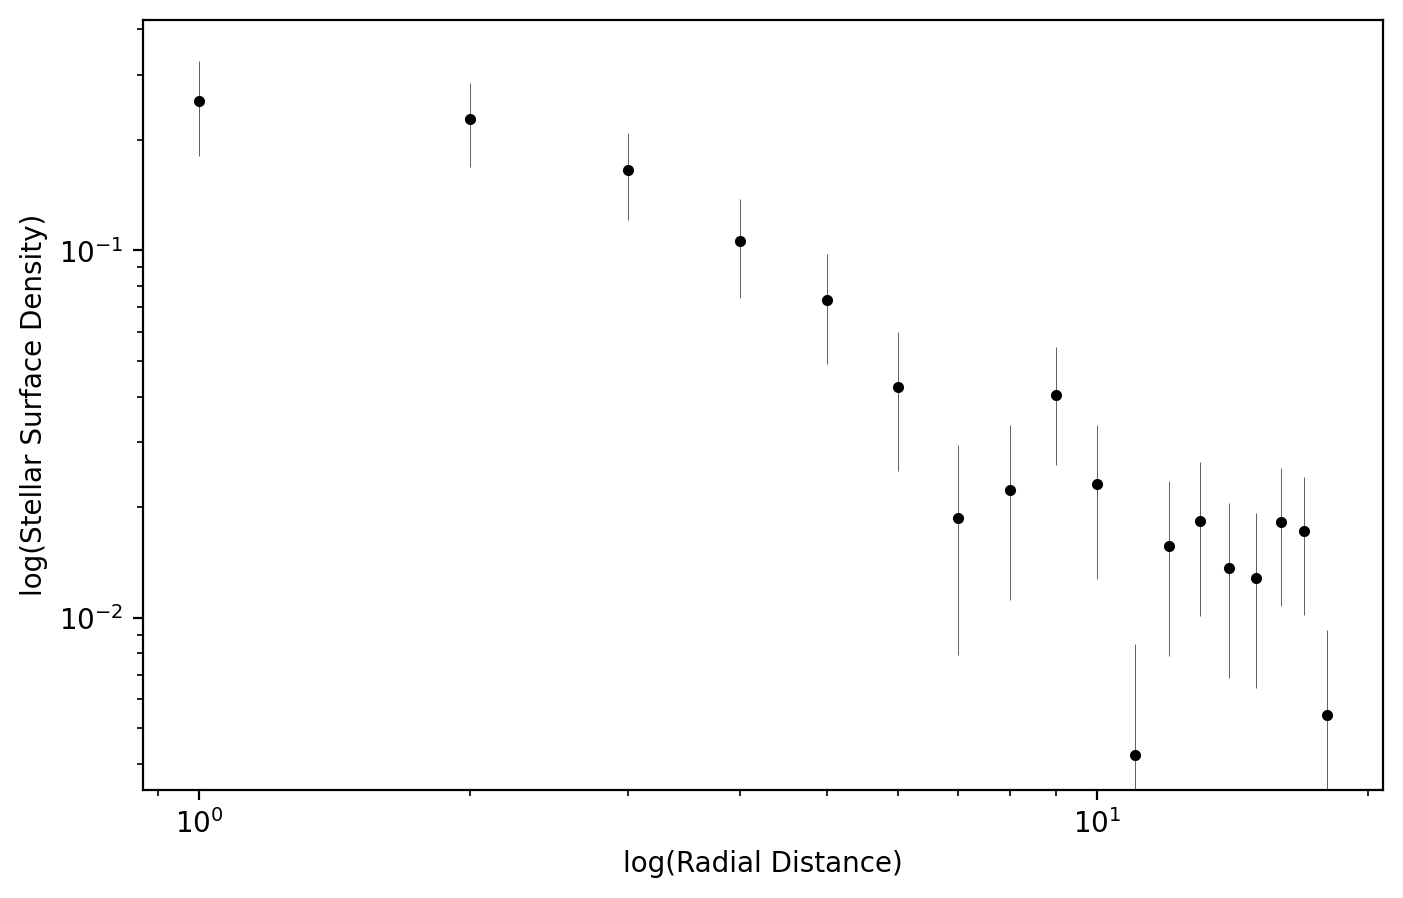

In [17]:
from scipy import stats
from scipy import optimize
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Create the plot
fig, ax = plt.subplots(figsize=(8, 5))

# Plot the data with error bars
ax.errorbar(n, y, y_err, fmt='.', color='black', ecolor='black', elinewidth=0.22)  # Adjust the width as needed


# Set labels for the axes
ax.set_xlabel('log(Radial Distance)')
ax.set_ylabel('log(Stellar Surface Density)')
plt.xscale("log")
plt.yscale("log")
# Show the plot
plt.show()

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import corner
import emcee
import time
import scipy.optimize as op


# Step 1: Load the data containing cluster members
data = pd.read_csv('FM.csv')

# Extract cluster members with membership probability > 0.5
cluster_members = data[data['CM'] > 0.5]

# Step 2: Define Radial Density Profile Model
def radial_density_profile(r, rho0, rc, rt ,rho_bg):
    # Define the radial density profile equation
    term1 = 1 / np.sqrt(1 + (r / rc)**2) - 1 / np.sqrt(1 + (rt / rc)**2)
    density = rho0 * term1**2 + rho_bg
    return density

# Step 3: Define Likelihood
def log_likelihood(parameters, n, y, y_err):
    # Compute the log likelihood of the data given the model and parameters
    rho0, rc, rt, rho_bg = parameters
    model_predictions = radial_density_profile(n, rho0, rc, rt,rho_bg)
    residuals = y - model_predictions
    chi_squared = np.sum((residuals / y_err)**2)
    return -0.5 * chi_squared

# Step 4: Define Priors
def log_prior(parameters):
    # Define prior distributions for the parameters
    rho0, rc, rt, rho_bg = parameters
    if 0 < rho0 < 4  and 0 < rc < 9 and 0 < rt < 21 and 0 < rho_bg < 1:
        return 0
    return -np.inf

# Step 5: Compute Posterior
def log_posterior(parameters, n, y, y_err):
    # Compute the log posterior given the likelihood and priors
    prior = log_prior(parameters)
    if not np.isfinite(prior):
        return -np.inf
    likelihood = log_likelihood(parameters, n, y, y_err)
    return prior + likelihood

In [24]:
n_walkers =2000
n_dimensions=4
n_steps = 1000  
burn_in = 200 

initial_param =np.array([1,2,4, 0.001])
l0 = [initial_param + 1e-4 * np.random.randn(n_dimensions) for _ in range(n_walkers)]

# Initialize the sampler
sampler = emcee.EnsembleSampler(n_walkers, n_dimensions, log_posterior, args=(n, y, y_err))
l0,_,_=sampler.run_mcmc(l0,250)
sampler.reset()

In [25]:
s=sampler.run_mcmc(l0,1500)
samples=sampler.flatchain

In [26]:
# Calculate the parameter estimates
parameter_estimates = np.percentile(samples, 50, axis=0)

# Calculate the parameter errors
lower_percentile = np.percentile(samples, 16, axis=0)
upper_percentile = np.percentile(samples, 84, axis=0)
parameter_errors = (upper_percentile - lower_percentile) / 2  # Half the interval between 16th and 84th percentiles
parameter_estimates

array([4.72409477e-01, 3.44878316e+00, 1.49531055e+01, 9.21130561e-03])

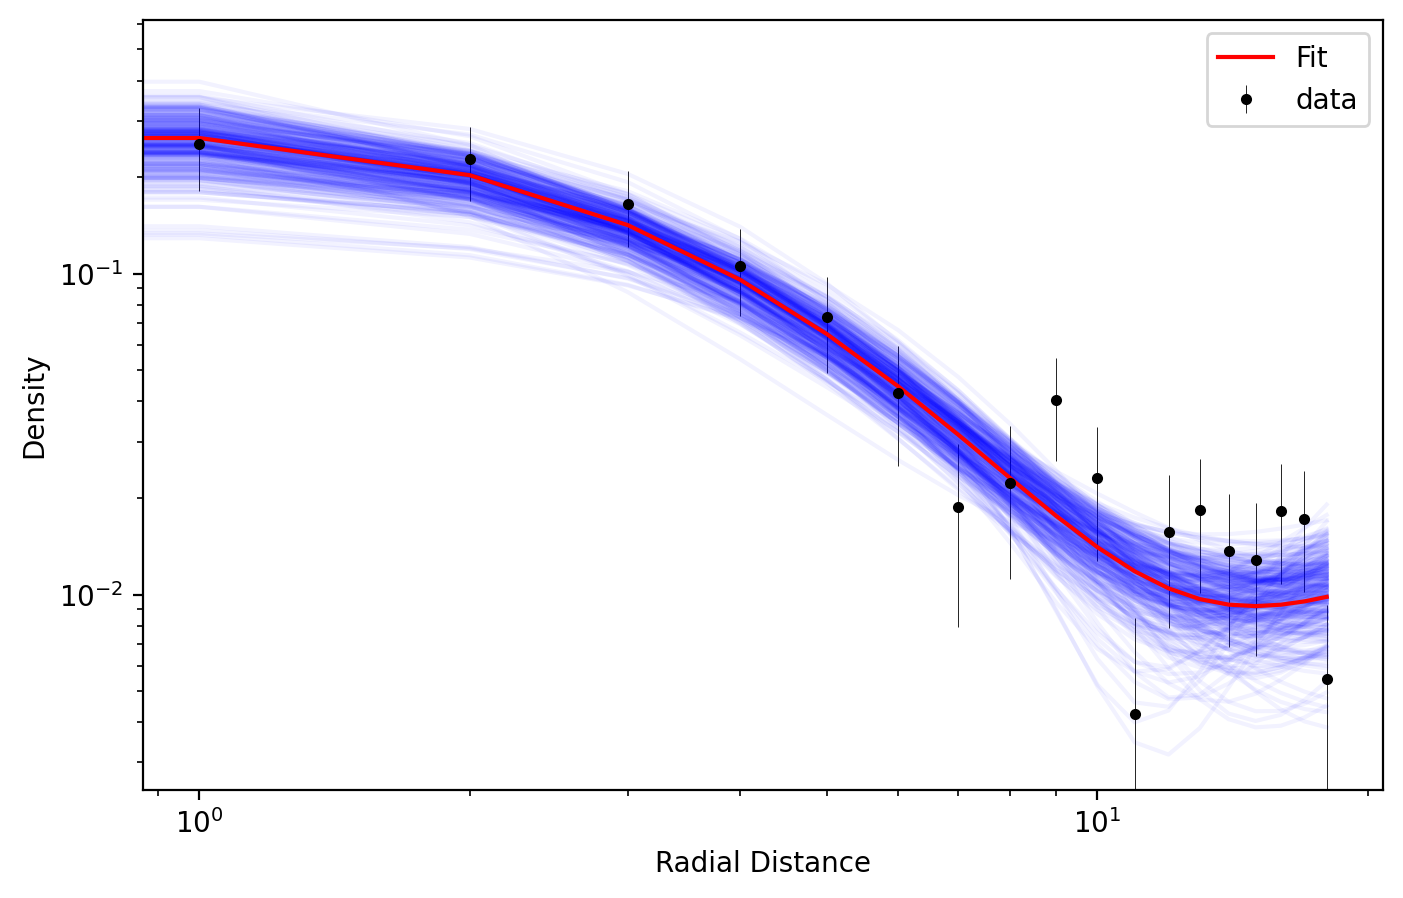

In [29]:
from scipy import stats
from scipy import optimize
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Step 3: Calculate the fitted curve using the parameter estimates
rho0_estimate, rc_estimate, rt_estimate, rho_bg_estimate = parameter_estimates
rho0_error, rc_error, rt_error, rho_bg_error = parameter_errors

fitted_curve_estimate = radial_density_profile(n,rho0_estimate, rc_estimate, rt_estimate, rho_bg_estimate)

# Step 4: Generate 300 random samples from the MCMC chain
random_samples = samples[np.random.choice(samples.shape[0], 300, replace=False)]
# Create the plot
fig, ax = plt.subplots(figsize=(8, 5))
# Plot the data with error bars
ax.errorbar(n, y, y_err, fmt='.', color='black', ecolor='black', elinewidth=0.3,label='data')


# Plot the sampled curves
for params in random_samples:
    rho0, rc, rt, rho_bg = params
    fitted_curve_sample = radial_density_profile(n, rho0, rc, rt, rho_bg)
    ax.plot(n, fitted_curve_sample, color='blue', alpha=0.05)
      
# Plot the fitted curve estimate
ax.plot(n, fitted_curve_estimate, color='red', label='Fit')



# Set labels for the axes
ax.set_xlabel('Radial Distance')
ax.set_ylabel('Density')

# Set scale to log for both axes
ax.set_xscale('log')
ax.set_yscale('log')

# Add legend
ax.legend()

# Show the plot
plt.show()

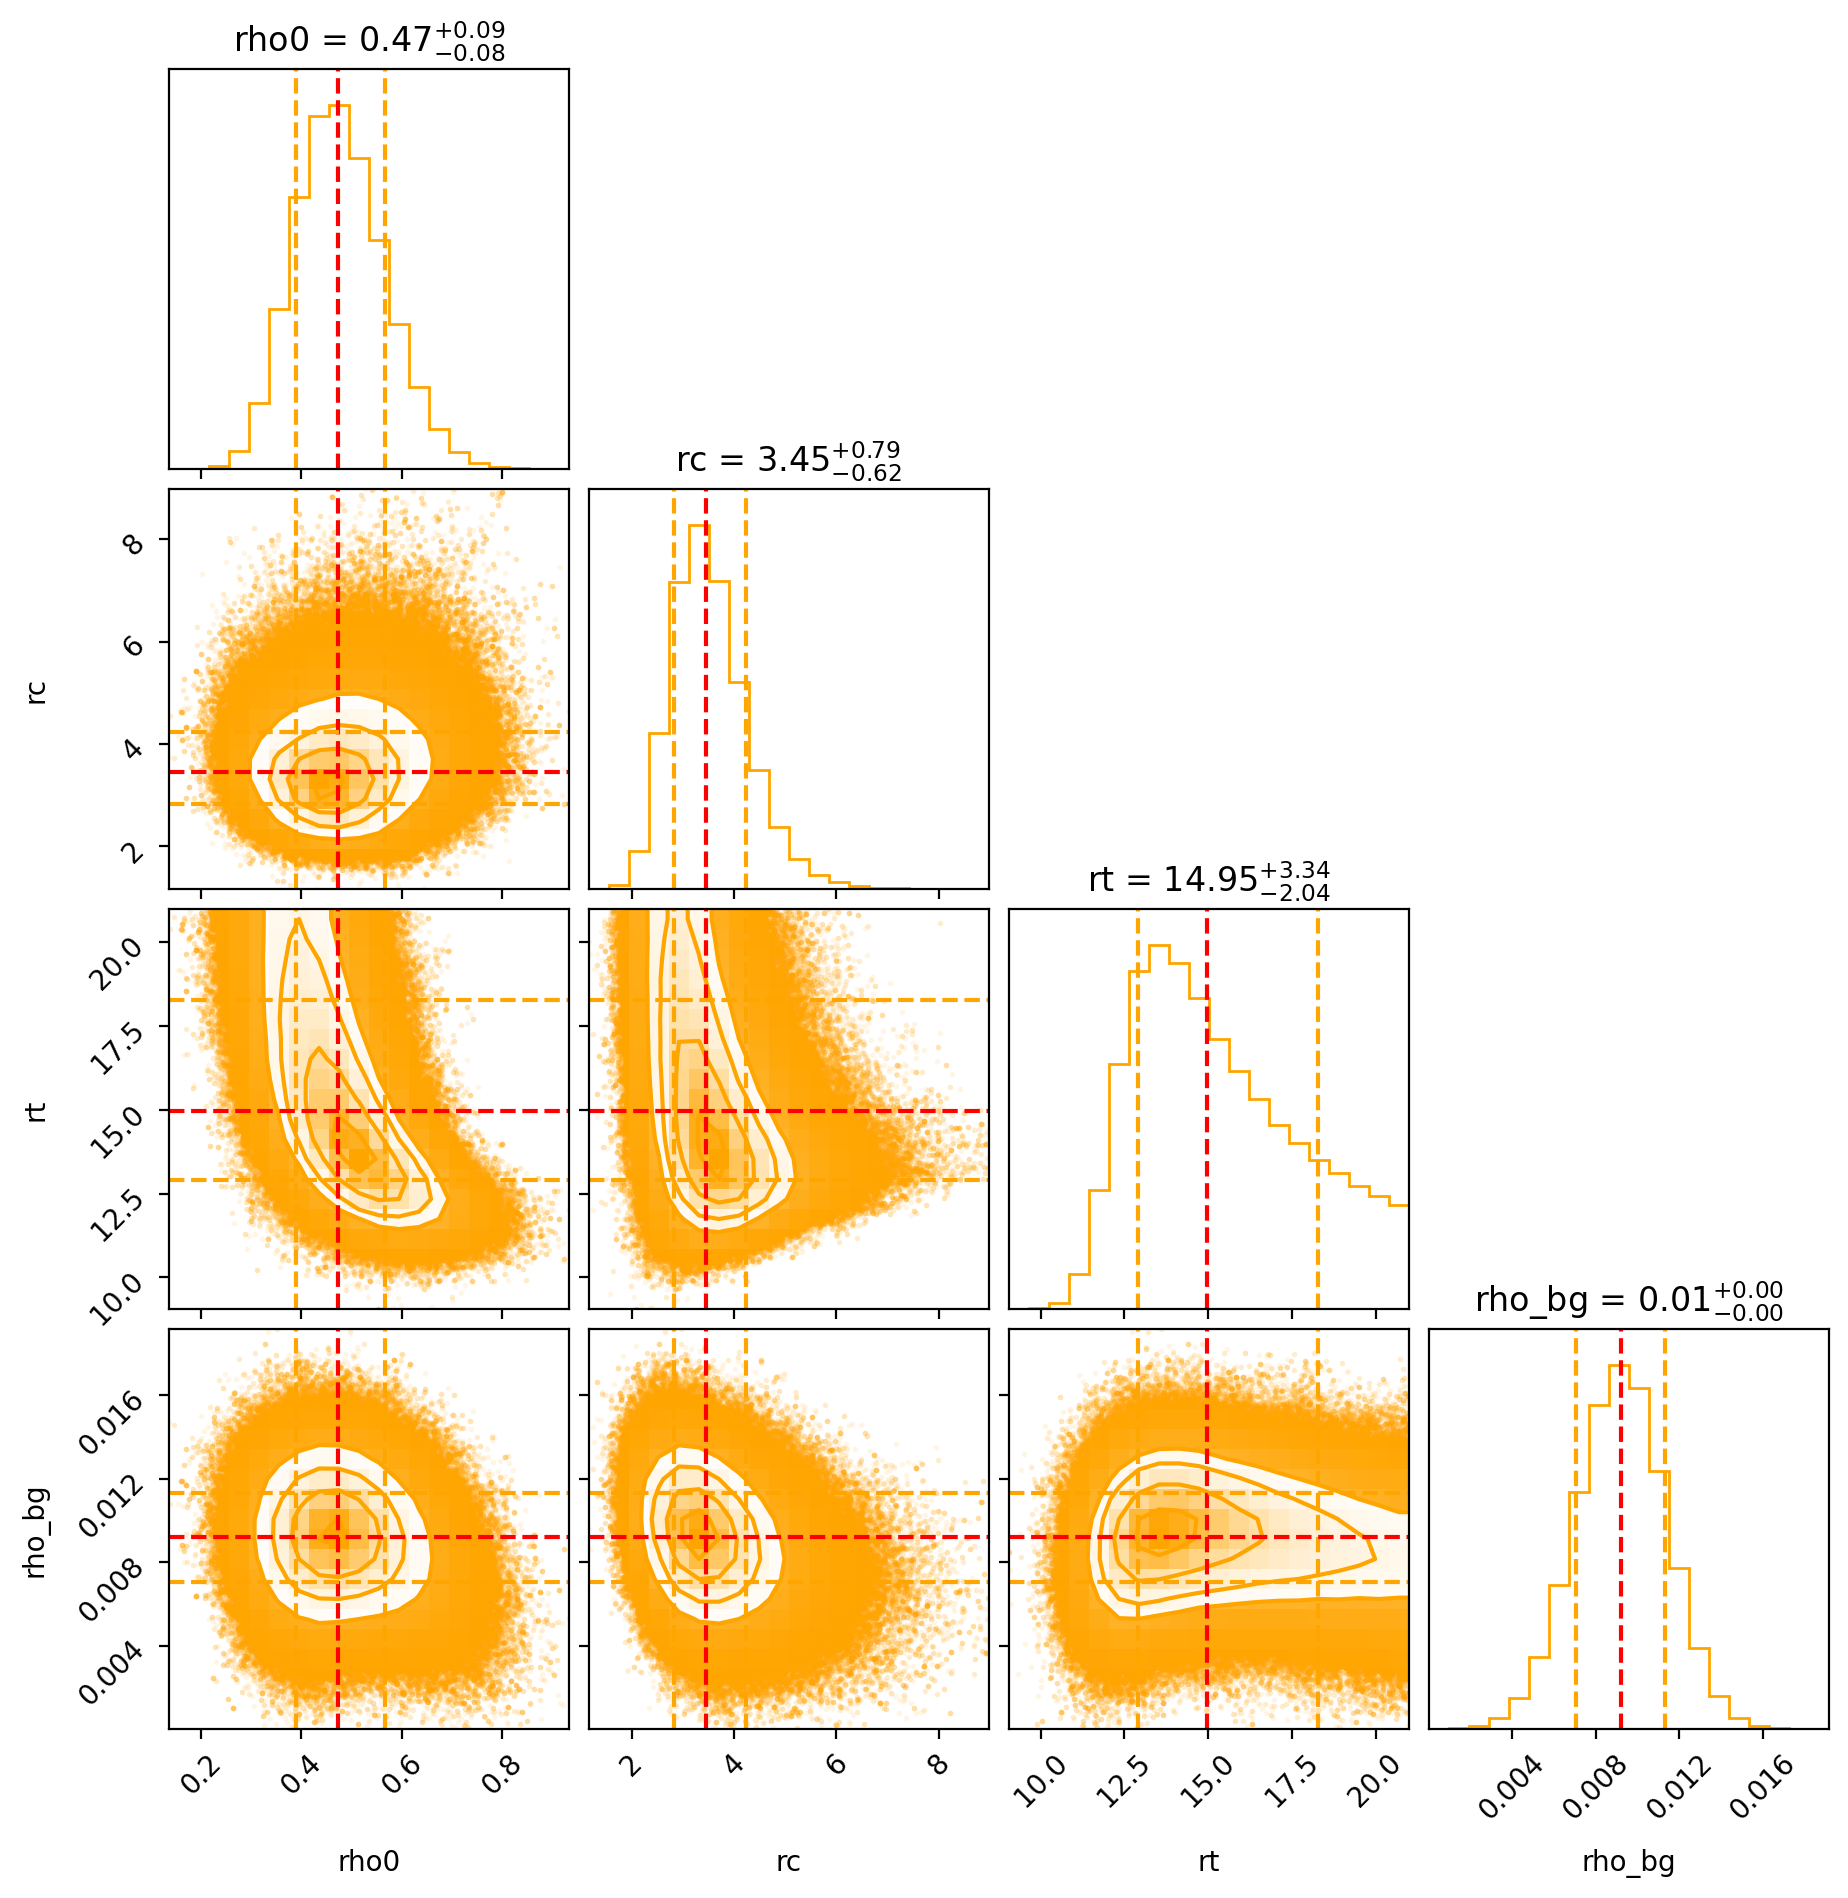

In [28]:
import corner

# Define parameter labels
parameter_labels = ['rho0', 'rc', 'rt', 'rho_bg']

value1 = np.percentile(samples, 16, axis=0)
value2 = np.percentile(samples, 50, axis=0)
value3 = np.percentile(samples, 84, axis=0)

ndim = 4
# Make the base corner plot
figure = corner.corner(samples, labels=parameter_labels, show_titles=True, color='orange')

# Extract the axes
axes = np.array(figure.axes).reshape((ndim, ndim))

# Loop over the diagonal
for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(value1[i], color="orange", linestyle='--')
    ax.axvline(value2[i], color="r", linestyle='--')
    ax.axvline(value3[i], color="orange", linestyle='--')

# Loop over the histograms
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(value1[xi], color="orange", linestyle='--')
        ax.axvline(value2[xi], color="r", linestyle='--')
        ax.axvline(value3[xi], color="orange", linestyle='--')
        ax.axhline(value1[yi], color="orange", linestyle='--')
        ax.axhline(value2[yi], color="r", linestyle='--')
        ax.axhline(value3[yi], color="orange", linestyle='--')
        ax.plot(value1[xi], value1[yi], "orange", linestyle='--')
        ax.plot(value2[xi], value2[yi], "r", linestyle='--')
        ax.plot(value3[xi], value3[yi], "orange", linestyle='--') 
